# Importing libraries

In [1]:
import os
import chemprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA              

C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    
    plt.show()
    
    return

# Generating Mordred descriptors

In [3]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
X_train = X_train.drop(['PCE_max(%)'], axis = 1)
X_train = X_train.drop([191])  # Mordred is  not able to calculate descriptors for acceptor at this posotion
X_train

X_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
X_val = X_val.drop(['PCE_max(%)'], axis = 1)
X_val

X_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
X_test = X_test.drop(['PCE_max(%)'], axis = 1)
X_test

,p(SMILES),n(SMILES)
0,CC1=CC(CCCCCC)=C(C)S1,O=C1N(CCCCCC)C(C2=C1N=CC(C#CC3=CC=C(C#CC(C=C4)...
1,O=C(OCC(CC)CCCC)C1=C(F)C2=C(C)SC(C3=CC4=C(C(C5...,O=C(N(C(CCCCC)CCCCC)C1=O)C2=CC3=C(C4=C5C=CC1C4...
2,CC1=CC(CCCCCC)=C(C)S1,CCCCCCC(C=C1)=CC=C1C2(C3=CC=C(CCCCCC)C=C3)C4=C...
3,CC1=CC(C(S1)=C2C3=CC(Cl)=C(CC(CC)CCCC)S3)=C(C4...,CCCCCCC(C=C1)=CC=C1C2(C3=CC=C(CCCCCC)C=C3)C4=C...
4,CC1=CC2=C(S1)C(C3=CC=C(SCCCCCCCC)S3)=C4C(OC(C5...,O=C(/C(S1)=C/C(C2=NSN=C32)=CC=C3C(S4)=CC5=C4C6...
...,...,...
127,O=C(OCC(CC)CCCC)C1=C(F)C2=C(C)SC(C3=CC4=C(C(C5...,CCCCCCC(C=C1)=CC=C1C(C2=C3SC(C4=C(CC(CC)CCCC)C...
128,CC(SC1=C2C3=CC=C(CC(CC)CCCC)S3)=CC1=C(C4=CC=C(...,O=C1C2=C(C(/C1=C/C3=CC4=C(C5=CC6=C(C=C5C4(C7=C...
129,CC1=CC(CCCCCC)=C(C)S1,O=C1C(C2=C(C3=CC=CS3)N1CCCCCCCCCCCC)=C(C4=CC=C...
130,CC(SC1=C2C3=CC=C(CC(CC)CCCC)S3)=CC1=C(C4=CC=C(...,CCCCCCC(C=C1)=CC=C1C(C2=CC=C(CCCCCC)C=C2)(O3)C...


In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm

def fp_list_from_smiles_list(smiles_list,n_bits=512):                        # This code snippet is taken from http://practicalcheminformatics.blogspot.com/2019/11/visualizing-chemical-space.html
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=512):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

donor_morgan_fp = fp_list_from_smiles_list(X_train['p(SMILES)'])
donor_morgan_fp_train = pd.DataFrame(donor_morgan_fp)

acceptor_morgan_fp = fp_list_from_smiles_list(X_train['n(SMILES)'])
acceptor_morgan_fp_train = pd.DataFrame(acceptor_morgan_fp)

frames_train = [donor_morgan_fp_train, acceptor_morgan_fp_train]
X_train_morgan = pd.concat(frames_train, axis =1)



donor_morgan_fp = fp_list_from_smiles_list(X_val['p(SMILES)'])
donor_morgan_fp_val = pd.DataFrame(donor_morgan_fp)

acceptor_morgan_fp = fp_list_from_smiles_list(X_val['n(SMILES)'])
acceptor_morgan_fp_val = pd.DataFrame(acceptor_morgan_fp)

frames_val = [donor_morgan_fp_val, acceptor_morgan_fp_val]
X_val_morgan = pd.concat(frames_val, axis =1)




donor_morgan_fp = fp_list_from_smiles_list(X_test['p(SMILES)'])
donor_morgan_fp_test = pd.DataFrame(donor_morgan_fp)

acceptor_morgan_fp = fp_list_from_smiles_list(X_test['n(SMILES)'])
acceptor_morgan_fp_test = pd.DataFrame(acceptor_morgan_fp)

frames_test = [donor_morgan_fp_test, acceptor_morgan_fp_test]
X_test_morgan = pd.concat(frames_test, axis =1)

X_train_morgan.to_csv('X_train_morgan.csv')
X_val_morgan.to_csv('X_val_morgan.csv')
X_test_morgan.to_csv('X_test_morgan.csv')


  0%|                                                                                         | 0/1053 [00:00<?, ?it/s]C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
100%|███████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 442.47it/s]


In [5]:
all_data = pd.concat([X_train_morgan,X_val_morgan,X_test_morgan])

In [6]:
all_data=all_data.select_dtypes(exclude=object)
all_data= all_data.replace([np.inf, -np.inf], np.nan)
all_data=all_data.dropna()
all_data= all_data.replace(np.nan,0)
print('Features with zero standard deviation :',len(all_data.std()[all_data.std() == 0]))
all_data=all_data.drop(all_data.std()[all_data.std() == 0].index.values, axis=1)   #To remove columns with std deviation equals to zero

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
a=sel.fit_transform(all_data)
sel.get_support()
features = all_data.columns[sel.get_support()]
print('Features selected by using variance threshold of 0.8 :',len(features))
f = features


X_train = X_train_morgan[f]
X_val = X_val_morgan[f]
X_test = X_test_morgan[f]

Features with zero standard deviation : 86
Features selected by using variance threshold of 0.8 : 126


In [7]:
y_train=pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
y_train = y_train.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)
y_train=y_train.drop([191])  # Mordred is  not able to calculate descriptors for acceptor at this posotion

y_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
y_val = y_val.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

y_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
y_test = y_test.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

In [8]:
# import pandas as pd
# import numpy as np

# X_train = pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
# X_train = X_train.drop(['PCE_max(%)'], axis = 1)
# X_train = X_train.drop([191])  # Mordred is  not able to calculate descriptors for acceptor at this posotion
# X_train

# X_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
# X_val = X_val.drop(['PCE_max(%)'], axis = 1)
# X_val

# X_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
# X_test = X_test.drop(['PCE_max(%)'], axis = 1)
# X_test


# from rdkit.Chem import Descriptors
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
# from mordred import Calculator,descriptors


# from rdkit.ML.Descriptors import MoleculeDescriptors
# des_list = [x[0] for x in Descriptors._descList]

# # Calculating Mordred descriptors for donors and acceptors
# def mordred_des(d,a):

#     smis = d   
#     mols = []
#     for smi in smis:
#         mols.append(Chem.MolFromSmiles(smi))
        
#     calc_d = Calculator(descriptors,ignore_3D=True)
    
# #     return calc_d.pandas(mols)


#     smis = a   
#     mols = []
#     for smi in smis:
#         mols.append(Chem.MolFromSmiles(smi))
        
#     calc_a = Calculator(descriptors,ignore_3D=True)
    
#     return pd.concat([calc_d.pandas(mols),calc_a.pandas(mols)], axis=1)


# D_smiles = X_train["p(SMILES)"]
# A_smiles = X_train["n(SMILES)"]
# X_train_mordred = mordred_des(D_smiles,A_smiles)

# D_smiles = X_val["p(SMILES)"]
# A_smiles = X_val["n(SMILES)"]
# X_val_mordred = mordred_des(D_smiles,A_smiles)

# D_smiles = X_test["p(SMILES)"]
# A_smiles = X_test["n(SMILES)"]
# X_test_mordred = mordred_des(D_smiles,A_smiles)

# X_train_mordred.to_csv('X_train_mordred.csv')
# X_val_mordred.to_csv('X_val_mordred.csv')
# X_test_mordred.to_csv('X_test_mordred.csv')

# Using saved files for Mordred descriptors

In [9]:
# X_train_mordred = pd.read_csv('X_train_mordred.csv')
# X_val_mordred = pd.read_csv('X_val_mordred.csv')
# X_test_mordred = pd.read_csv('X_test_mordred.csv')

In [10]:
y_train=pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
y_train = y_train.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)
y_train=y_train.drop([191])  # Mordred is  not able to calculate descriptors for acceptor at this posotion

y_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
y_val = y_val.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

y_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
y_test = y_test.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

In [11]:
# all_data = pd.concat([X_train_mordred,X_val_mordred,X_test_mordred])

# all_data=all_data.select_dtypes(include='number')  
# print('Features with zero standard deviation :',len(all_data.std()[all_data.std() == 0])) #displaying features with zero std deviation
# all_data=all_data.drop(all_data.std()[all_data.std() == 0].index.values, axis=1)  # Dropping features with zero std deviation
# all_data = all_data.replace([np.inf, -np.inf], np.nan)
# all_data = all_data.replace(np.nan,0)  #replace null values with zero

# def correlation(dataset, threshold):
#     col_corr = set()  # Set of all the names of correlated columns
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
#                 colname = corr_matrix.columns[i]  # getting the name of column
#                 col_corr.add(colname)
#     return col_corr
# corr_features = correlation(all_data, 0.8)
# print('Features with correlation more than 0.8 :',len(set(corr_features)))
# all_data=all_data.drop(corr_features,axis=1)   # Dropping features with correlation more than 0.8

# X_train=X_train_mordred[all_data.columns]
# X_val=X_val_mordred[all_data.columns]
# X_test=X_test_mordred[all_data.columns]

In [12]:
# X_train[np.isinf(X_train).any(1)]

In [13]:
# Defining Metrics
def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2
def PearsonCoefficient(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr
def MSE(X,Y):
    mse=mean_squared_error(X,Y)
    return mse
def RMSE(X,Y):
    rmse=np.sqrt(mean_squared_error(X,Y))
    return rmse
def MAPE(X,Y):
    mape=np.average(abs(np.array(X)-np.array(Y))/np.array(Y))*100
    return mape


from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from scipy.stats.stats import pearsonr

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [15]:
# Normalize input variables using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [16]:
import torch.nn.functional as F
class ANN(nn.Module):
    
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x


torch.manual_seed(42)
# ANN = ANN()
# net=net.cuda()

In [17]:
input_size = X_train.shape[1]
model = ANN(input_size)

learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [18]:
X_train = torch.tensor(X_train).type(torch.float32)
y_train = torch.tensor(np.array(y_train)).type(torch.float32)

X_val = torch.tensor(X_val).type(torch.float32)
y_val = torch.tensor(np.array(y_val)).type(torch.float32)

X_test = torch.tensor(X_test).type(torch.float32)
y_test = torch.tensor(np.array(y_test)).type(torch.float32)

In [19]:
# # Train the model
# n_epochs = 400
# train_losses = []
# val_losses = []

# for epoch in range(n_epochs):
#     # Train the model
#     model.train()
#     optimizer.zero_grad()
#     y_pred_train = model(X_train)
#     loss_train = criterion(y_pred_train.squeeze(), y_train.squeeze())
#     loss_train.backward()
#     optimizer.step()
#     train_losses.append(loss_train.item())

#     # Evaluate the model on validation set
#     model.eval()
#     with torch.no_grad():
#         y_pred_val = model(X_val)
#         loss_val = criterion(y_pred_val.squeeze(), y_val.squeeze())
#         val_losses.append(loss_val.item())

#     # Print progress
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch} - Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")

In [20]:
# Train the model
n_epochs = 400
train_losses = []
val_losses = []
patience = 10  # number of epochs to wait for validation loss improvement before stopping early
best_val_loss = float('inf')
best_model = None
no_improvement_count = 0  # count of epochs with no improvement in validation loss

for epoch in range(n_epochs):
    # Train the model
    model.train()
    optimizer.zero_grad()
    y_pred_train = model(X_train)
    loss_train = criterion(y_pred_train.squeeze(), y_train.squeeze())
    loss_train.backward()
    optimizer.step()
    train_losses.append(loss_train.item())

    # Evaluate the model on validation set
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val)
        loss_val = criterion(y_pred_val.squeeze(), y_val.squeeze())
        val_losses.append(loss_val.item())

    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")
        

Epoch 0 - Train Loss: 79.8748, Validation Loss: 77.7794
Epoch 10 - Train Loss: 74.4383, Validation Loss: 72.4045
Epoch 20 - Train Loss: 68.4978, Validation Loss: 66.3847
Epoch 30 - Train Loss: 60.1281, Validation Loss: 57.7362
Epoch 40 - Train Loss: 46.0507, Validation Loss: 43.1282
Epoch 50 - Train Loss: 24.9670, Validation Loss: 22.3706
Epoch 60 - Train Loss: 11.8452, Validation Loss: 10.9742
Epoch 70 - Train Loss: 8.6400, Validation Loss: 8.2395
Epoch 80 - Train Loss: 7.5020, Validation Loss: 7.2595
Epoch 90 - Train Loss: 6.9437, Validation Loss: 6.8087
Epoch 100 - Train Loss: 6.5950, Validation Loss: 6.5568
Epoch 110 - Train Loss: 6.3395, Validation Loss: 6.3842
Epoch 120 - Train Loss: 6.1353, Validation Loss: 6.2567
Epoch 130 - Train Loss: 5.9648, Validation Loss: 6.1589
Epoch 140 - Train Loss: 5.8179, Validation Loss: 6.0818
Epoch 150 - Train Loss: 5.6904, Validation Loss: 6.0215
Epoch 160 - Train Loss: 5.5777, Validation Loss: 5.9733
Epoch 170 - Train Loss: 5.4775, Validation Lo

In [21]:
# Load the best model (based on validation loss) and evaluate on test data
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    loss_test = criterion(y_pred_test.squeeze(), y_test.squeeze())
print(f"Test Loss: {loss_test.item():.4f}")

Test Loss: 5.5614


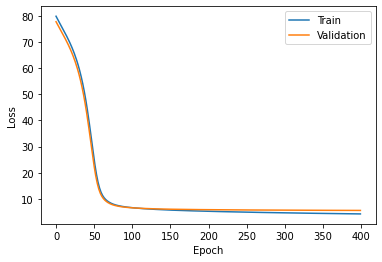

In [22]:
# Plot the training and validation loss curves
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
y_pred_test = model(torch.Tensor(X_test))

In [24]:
y_test = y_test.reshape(132)
y_pred_test = y_pred_test.reshape(132)

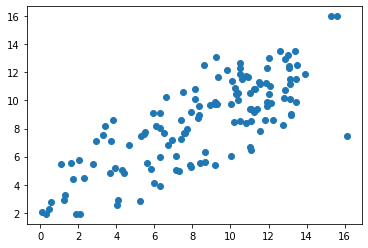

In [25]:
y_test = y_test.detach().numpy()
y_pred_test = y_pred_test.detach().numpy()
plt.scatter(y_test,y_pred_test)

In [26]:
print('R2 Score: ',R2Score(y_test, y_pred_test))

R2 Score:  0.6187560828595609


In [27]:
PearsonCoefficient(y_test, y_pred_test)

0.7871692375666006

In [28]:
import numpy as np
RMSE(y_test, y_pred_test)

2.3582633